<a href="https://colab.research.google.com/github/Davidmide02/text-analysis/blob/main/text_classification(sms).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikeras

 [Link to dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset?resource=download)

 Download the dataset from Kaggle and upload it to the working environment here and rull all the cells

Dataset shape: (5572, 2)
Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
Percentage of spam: 13.41%
Missing values:
label      0
message    0
dtype: int64


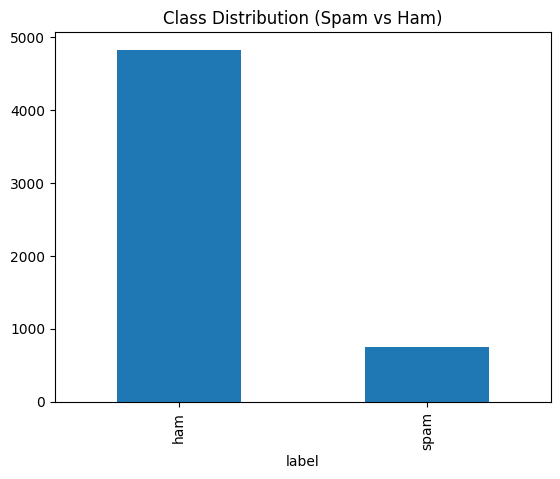

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data. Note: This dataset often has a tricky encoding, we'll use the latin-1; .
df = pd.read_csv('spam.csv', encoding='latin-1')

# Clean the dataframe (it often has extra unnamed columns)
df = df[['v1', 'v2']] # Keep only the label (v1) and text (v2) columns
df.columns = ['label', 'message']

# Basic Exploration
print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")
print(f"Percentage of spam: { (df['label']=='spam').mean() * 100:.2f}%")

# Check for missing values
print(f"Missing values:\n{df.isnull().sum()}")

# Visualize class distribution
df['label'].value_counts().plot(kind='bar', title='Class Distribution (Spam vs Ham)')
plt.show()

# Phase 1: Data Preprocessing & Feature Engineering (Next Steps)Label Encoding & Train-Test Split:

In [ ]:
from sklearn.model_selection import train_test_split

# Convert labels to binary (0 for ham, 1 for spam)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Split into features (X) and target (y)
X = df['message']
y = df['label']

# Split into train and test sets. Use stratification because of the imbalance.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set spam %: {y_train.mean():.3f}")
print(f"Test set spam %: {y_test.mean():.3f}")

Training set size: 4457
Test set size: 1115
Training set spam %: 0.134
Test set spam %: 0.134


### 2. Advanced Text Preprocessing Function:


In [ ]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove extra characters - keep letters and basic punctuation?
    # Let's keep only alphanumeric and spaces for simplicity
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 3. Tokenize
    words = text.split()

    # 4. Remove stopwords (we'll try this, but can be treated as hyperparameter)
    words = [w for w in words if w not in stop_words]

    # 5. Lemmatize
    words = [lemmatizer.lemmatize(w) for w in words]

    return ' '.join(words)

# Apply preprocessing
X_train_clean = X_train.apply(preprocess_text)
X_test_clean = X_test.apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


3. Dual-Path Text Representation:

Path A: TF-IDF for Dense Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)  # Limit features to manage dimensionality
X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tidf = tfidf.transform(X_test_clean)

1. Path B: Tokenization & Padding for RNN Models

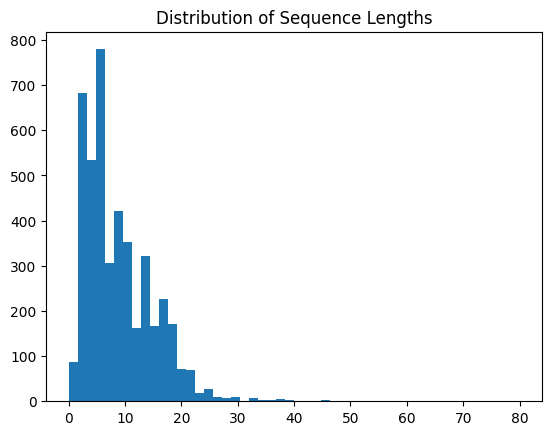

Chosen sequence length: 20
Vocabulary size: 6986


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_clean)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

# Pad sequences - let's analyze the length first
import matplotlib.pyplot as plt

seq_lengths = [len(seq) for seq in X_train_seq]
plt.hist(seq_lengths, bins=50)
plt.title("Distribution of Sequence Lengths")
plt.show()

# Choose maxlen based on the distribution (e.g., 95th percentile)
maxlen = int(np.percentile(seq_lengths, 95))
print(f"Chosen sequence length: {maxlen}")

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
print(f"Vocabulary size: {vocab_size}")

### 4. Handle Class Imbalance


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")
# This will give higher weight to the spam class during training

Class weights: {0: np.float64(0.577481212749417), 1: np.float64(3.7265886287625416)}


# Phase 2: Model Building & Training


### Dense Model (TF-IDF):

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Dropout, Embedding, LSTM, GRU, Flatten
from tensorflow.keras.optimizers import Adam

dense_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# complie

dense_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### LSTM Model

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM

lstm_model = Sequential([
    Embedding(vocab_size, 100, input_length=maxlen),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### GRU Model:

In [ ]:
from tensorflow.keras.layers import GRU

gru_model = Sequential([
    Embedding(vocab_size, 100, input_length=maxlen),
    GRU(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

In [ ]:
gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Print model summaries
print("DENSE MODEL SUMMARY:")
dense_model.summary()

print("\nLSTM MODEL SUMMARY:")
lstm_model.summary()

print("\nGRU MODEL SUMMARY:")
gru_model.summary()

DENSE MODEL SUMMARY:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)


LSTM MODEL SUMMARY:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


GRU MODEL SUMMARY:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Step 2: Set Up Training with Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001
)

callbacks = [early_stopping, reduce_lr]

# Train all three models

In [ ]:
# Convert TF-IDF sparse matrix to dense for Keras (if needed)
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tidf.toarray()

print("Starting model training...")

# Train Dense Model
print("\n=== TRAINING DENSE MODEL ===")
history_dense = dense_model.fit(
    X_train_tfidf_dense, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# Train LSTM Model
print("\n=== TRAINING LSTM MODEL ===")
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# Train GRU Model
print("\n=== TRAINING GRU MODEL ===")
history_gru = gru_model.fit(
    X_train_pad, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Starting model training...

=== TRAINING DENSE MODEL ===
Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8607 - loss: 0.6323 - val_accuracy: 0.9417 - val_loss: 0.2551 - learning_rate: 0.0010
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9689 - loss: 0.1678 - val_accuracy: 0.9574 - val_loss: 0.1230 - learning_rate: 0.0010
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9831 - loss: 0.0590 - val_accuracy: 0.9742 - val_loss: 0.1033 - learning_rate: 0.0010
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9859 - loss: 0.0405 - val_accuracy: 0.9619 - val_loss: 0.1067 - learning_rate: 0.0010
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9923 - loss: 0.0174 - val_accuracy: 0.9709 - val_loss: 0.1051 - learning_rate: 0.0010
Epoch 6/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9986 - loss: 0.0080 - val_accuracy: 0.9709 - val_loss: 0.1097 - learning_rate: 0.0010
Epoch 7/30
112/112 ━━━━━━

# Evaluation & Basic Analysis

In [ ]:
# Evaluate all models on test set
print("\n=== MODEL EVALUATION ===")

# Dense Model
dense_test_loss, dense_test_accuracy = dense_model.evaluate(X_test_tfidf_dense, y_test)
print(f"Dense Model - Test Accuracy: {dense_test_accuracy:.4f}")

# LSTM Model
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f"LSTM Model - Test Accuracy: {lstm_test_accuracy:.4f}")

# GRU Model
gru_test_loss, gru_test_accuracy = gru_model.evaluate(X_test_pad, y_test)
print(f"GRU Model - Test Accuracy: {gru_test_accuracy:.4f}")


=== MODEL EVALUATION ===
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9642 - loss: 0.1104
Dense Model - Test Accuracy: 0.9686
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9765 - loss: 0.0743
LSTM Model - Test Accuracy: 0.9731
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9828 - loss: 0.0716
GRU Model - Test Accuracy: 0.9812


 ### Generate Comprehensive Metrics & Confusion Matrices:

COMPREHENSIVE MODEL EVALUATION
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

=== DENSE NETWORK CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         Ham       0.98      0.98      0.98       966
        Spam       0.88      0.89      0.88       149

    accuracy                           0.97      1115
   macro avg       0.93      0.93      0.93      1115
weighted avg       0.97      0.97      0.97      1115



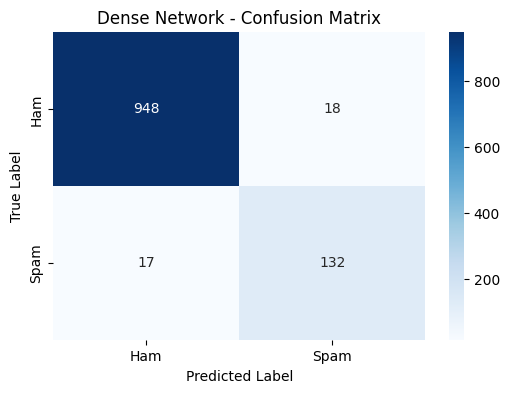

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

=== LSTM NETWORK CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.98       966
        Spam       0.92      0.87      0.90       149

    accuracy                           0.97      1115
   macro avg       0.95      0.93      0.94      1115
weighted avg       0.97      0.97      0.97      1115



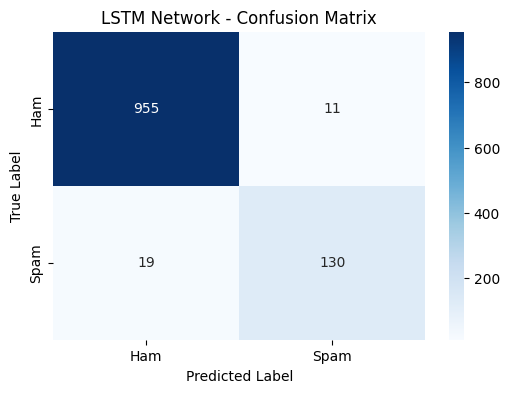

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

=== GRU NETWORK CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       1.00      0.86      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



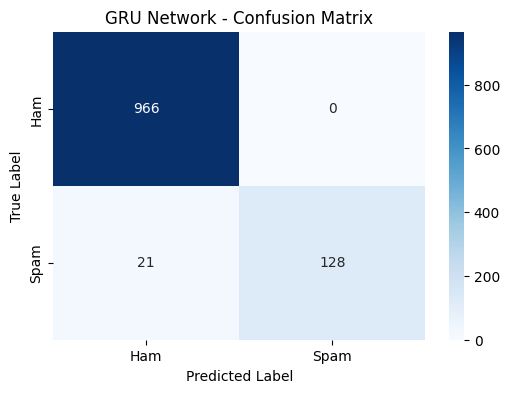

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive evaluation for a single model"""
    # Generate predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print classification report
    print(f"\n=== {model_name.upper()} CLASSIFICATION REPORT ===")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'],
                yticklabels=['Ham', 'Spam'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Evaluate all models
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 50)

# For Dense model (using TF-IDF)
results_dense = evaluate_model(dense_model, X_test_tfidf_dense, y_test, "Dense Network")

# For LSTM model (using padded sequences)
results_lstm = evaluate_model(lstm_model, X_test_pad, y_test, "LSTM Network")

# For GRU model (using padded sequences)
results_gru = evaluate_model(gru_model, X_test_pad, y_test, "GRU Network")

### Comparative result table

In [ ]:
# Create comparison table
results_comparison = pd.DataFrame({
    'Dense': results_dense,
    'LSTM': results_lstm,
    'GRU': results_gru
}).T

print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(results_comparison.round(4))

# Highlight best performance in each metric
styled_comparison = results_comparison.style.highlight_max(color='lightgreen', axis=0)
styled_comparison


=== MODEL PERFORMANCE COMPARISON ===
       accuracy  precision  recall      f1
Dense    0.9686      0.880  0.8859  0.8829
LSTM     0.9731      0.922  0.8725  0.8966
GRU      0.9812      1.000  0.8591  0.9242


,accuracy,precision,recall,f1
Dense,0.968610,0.880000,0.885906,0.882943
LSTM,0.973094,0.921986,0.872483,0.896552
GRU,0.981166,1.000000,0.859060,0.924188


### Plot Training Histories for all models

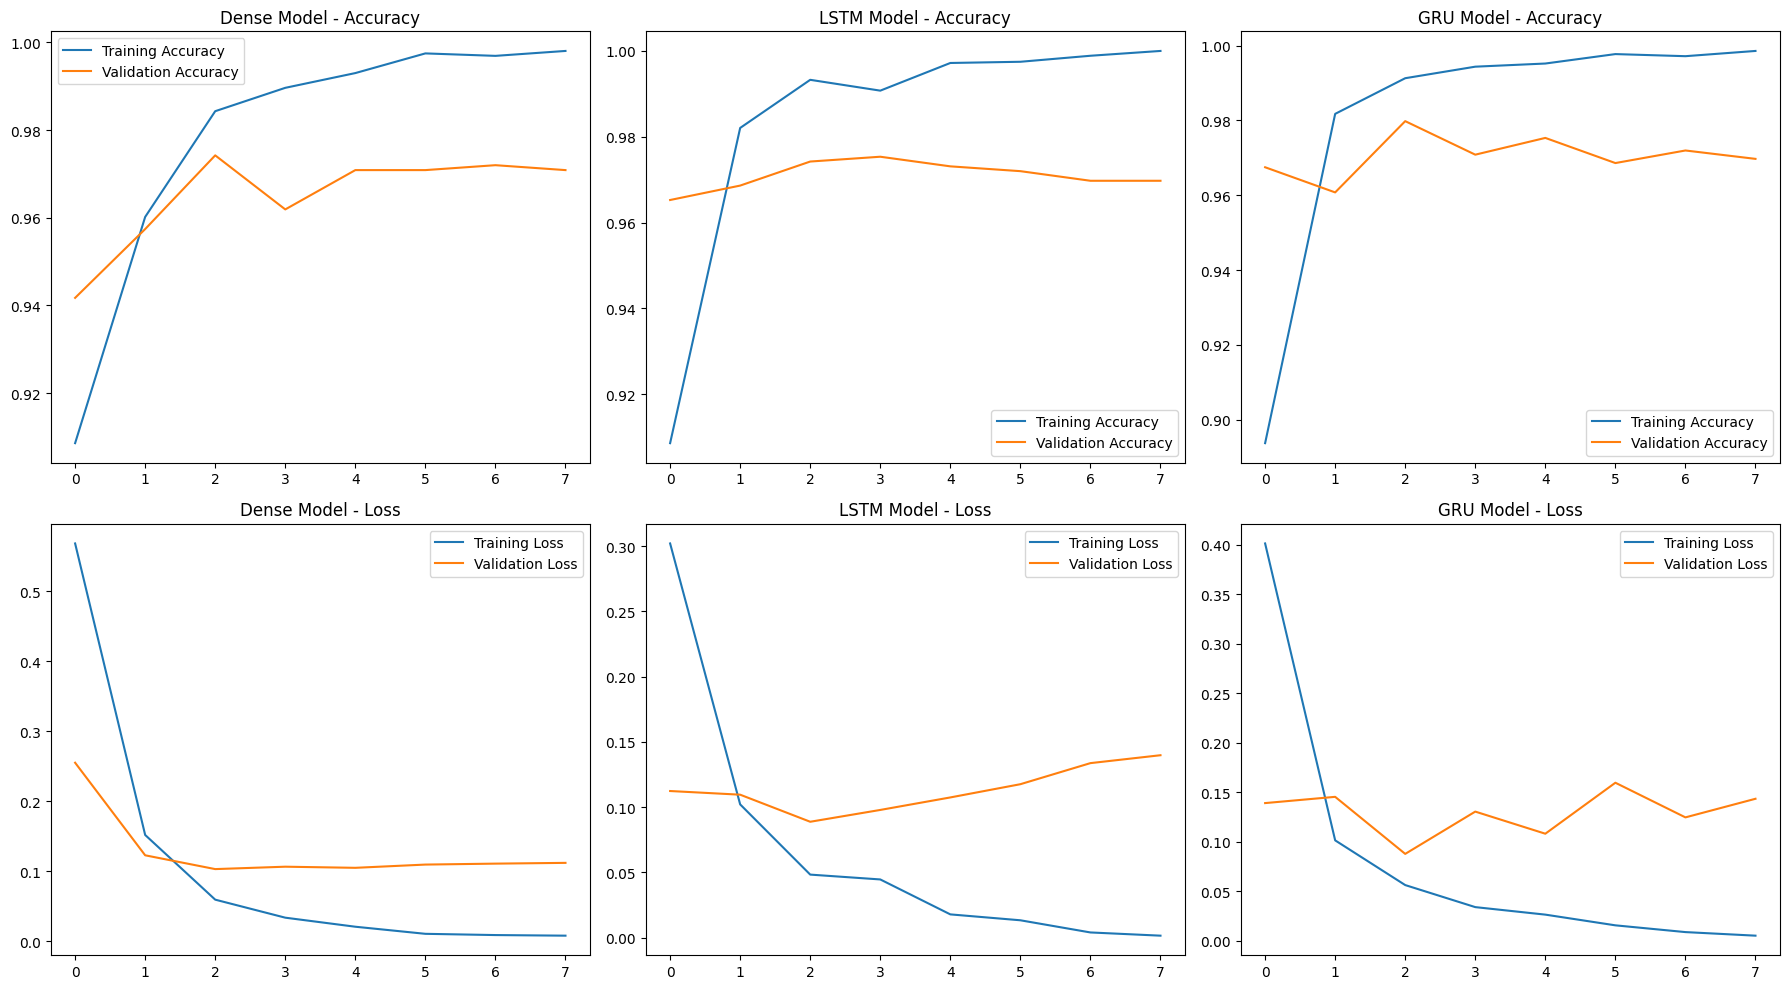

In [ ]:
# Plot training history comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Dense Model History
axes[0,0].plot(history_dense.history['accuracy'], label='Training Accuracy')
axes[0,0].plot(history_dense.history['val_accuracy'], label='Validation Accuracy')
axes[0,0].set_title('Dense Model - Accuracy')
axes[0,0].legend()

axes[1,0].plot(history_dense.history['loss'], label='Training Loss')
axes[1,0].plot(history_dense.history['val_loss'], label='Validation Loss')
axes[1,0].set_title('Dense Model - Loss')
axes[1,0].legend()

# LSTM Model History
axes[0,1].plot(history_lstm.history['accuracy'], label='Training Accuracy')
axes[0,1].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
axes[0,1].set_title('LSTM Model - Accuracy')
axes[0,1].legend()

axes[1,1].plot(history_lstm.history['loss'], label='Training Loss')
axes[1,1].plot(history_lstm.history['val_loss'], label='Validation Loss')
axes[1,1].set_title('LSTM Model - Loss')
axes[1,1].legend()

# GRU Model History
axes[0,2].plot(history_gru.history['accuracy'], label='Training Accuracy')
axes[0,2].plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
axes[0,2].set_title('GRU Model - Accuracy')
axes[0,2].legend()

axes[1,2].plot(history_gru.history['loss'], label='Training Loss')
axes[1,2].plot(history_gru.history['val_loss'], label='Validation Loss')
axes[1,2].set_title('GRU Model - Loss')
axes[1,2].legend()

plt.tight_layout()
plt.show()

### Analyze Model Size and Training Efficiency:

In [ ]:
# Model complexity analysis
def get_model_size(model):
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    return trainable_params, non_trainable_params

print("\n=== MODEL COMPLEXITY ANALYSIS ===")
models = {'Dense': dense_model, 'LSTM': lstm_model, 'GRU': gru_model}
for name, model in models.items():
    trainable, non_trainable = get_model_size(model)
    print(f"{name} Model - Trainable params: {trainable:,}, Non-trainable: {non_trainable:,}")


=== MODEL COMPLEXITY ANALYSIS ===
Dense Model - Trainable params: 648,449, Non-trainable: 0.0
LSTM Model - Trainable params: 779,101, Non-trainable: 0.0
GRU Model - Trainable params: 759,301, Non-trainable: 0.0


# Phase 3: Hyperparameter Tuning (After Baseline Training)

### Manual Tuning

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Define hyperparameter combinations to test
hyperparameter_sets = [
    {'units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32},
    {'units': 150, 'dropout_rate': 0.4, 'learning_rate': 0.0005, 'batch_size': 64},
    {'units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32},  # Original baseline
    {'units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32},
]

best_f1 = 0
best_params = {}
best_model = None
results = []

print("Starting Manual Hyperparameter Tuning...")
print("=" * 50)

for i, params in enumerate(hyperparameter_sets):
    print(f"\n--- Testing Set {i+1}/{len(hyperparameter_sets)} ---")
    print(f"Parameters: {params}")

    # Create model
    model = Sequential([
        Embedding(vocab_size, 100, input_length=maxlen),
        LSTM(params['units'], dropout=params['dropout_rate'], recurrent_dropout=params['dropout_rate']),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        X_train_pad, y_train,
        epochs=25,
        batch_size=params['batch_size'],
        validation_split=0.2,
        class_weight=class_weight_dict,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate on validation set
    y_val_pred_proba = model.predict(X_train_pad[-223:], verbose=0)  # Last 20% as validation
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    current_f1 = f1_score(y_train[-223:], y_val_pred)

    print(f"Validation F1-score: {current_f1:.4f}")

    results.append({
        'params': params,
        'f1_score': current_f1,
        'model': model,
        'history': history
    })

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_params = params
        best_model = model
        print("🎯 New best model found!")

# Display all results
print("\n" + "="*50)
print("HYPERPARAMETER TUNING RESULTS")
print("="*50)
for i, result in enumerate(results):
    print(f"Set {i+1}: F1={result['f1_score']:.4f}, Params={result['params']}")

print(f"\n=== BEST MODEL ===")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best Parameters: {best_params}")

Starting Manual Hyperparameter Tuning...

--- Testing Set 1/4 ---
Parameters: {'units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation F1-score: 0.9296
🎯 New best model found!

--- Testing Set 2/4 ---
Parameters: {'units': 150, 'dropout_rate': 0.4, 'learning_rate': 0.0005, 'batch_size': 64}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation F1-score: 0.9315
🎯 New best model found!

--- Testing Set 3/4 ---
Parameters: {'units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation F1-score: 0.9429
🎯 New best model found!

--- Testing Set 4/4 ---
Parameters: {'units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation F1-score: 0.9706
🎯 New best model found!

HYPERPARAMETER TUNING RESULTS
Set 1: F1=0.9296, Params={'units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}
Set 2: F1=0.9315, Params={'units': 150, 'dropout_rate': 0.4, 'learning_rate': 0.0005, 'batch_size': 64}
Set 3: F1=0.9429, Params={'units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Set 4: F1=0.9706, Params={'units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}

=== BEST MODEL ===
Best F1 Score: 0.9706
Best Parameters: {'units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}


## Phase 5: Final Model Evaluation & Comparison

=== FINAL EVALUATION OF TUNED LSTM MODEL ===
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

=== TUNED LSTM CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.99      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



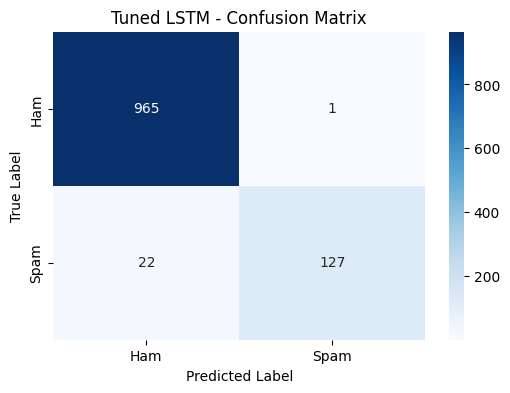


=== FINAL MODEL COMPARISON ===
            accuracy  precision  recall      f1
Dense         0.9686     0.8800  0.8859  0.8829
LSTM          0.9731     0.9220  0.8725  0.8966
GRU           0.9812     1.0000  0.8591  0.9242
LSTM_Tuned    0.9794     0.9922  0.8523  0.9170


In [ ]:
# Evaluate the best tuned model on the test set
print("=== FINAL EVALUATION OF TUNED LSTM MODEL ===")
tuned_results = evaluate_model(best_model, X_test_pad, y_test, "Tuned LSTM")

# Update the comparison table
final_comparison = results_comparison.copy()
final_comparison.loc['LSTM_Tuned'] = tuned_results

print("\n=== FINAL MODEL COMPARISON ===")
print(final_comparison.round(4))

## Phase 6: Generate Final Visualizations for Report

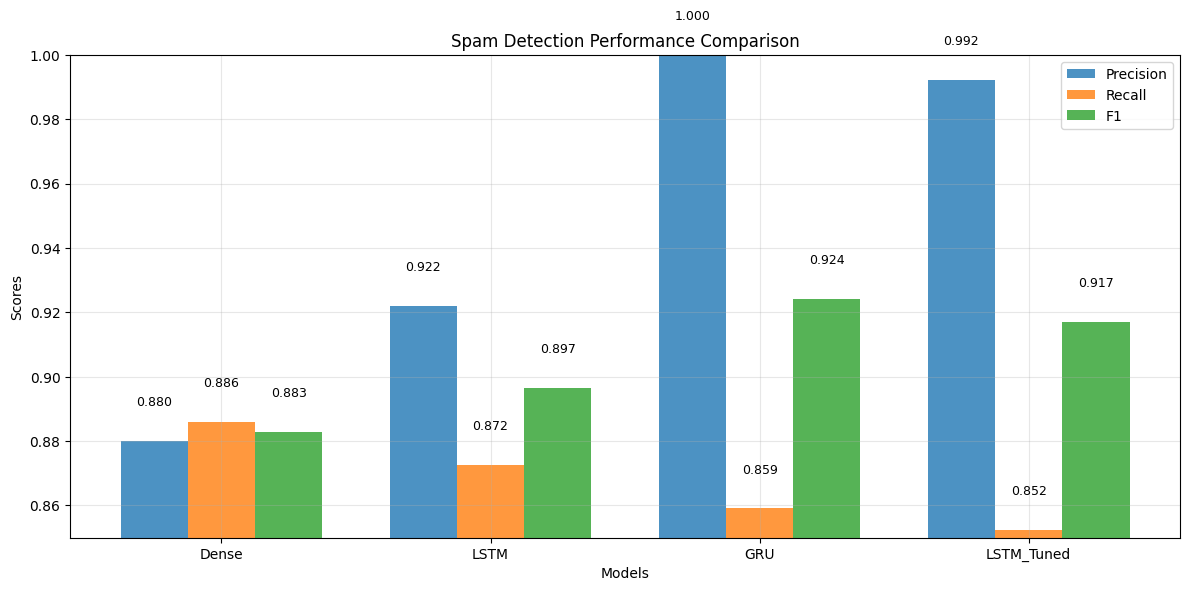

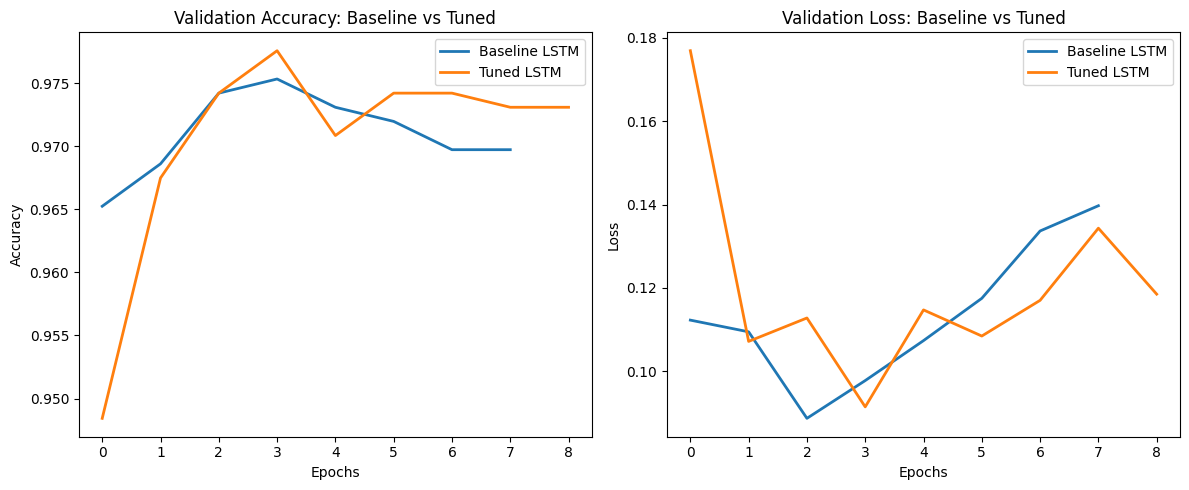

In [ ]:
# 1. Performance Comparison Chart
plt.figure(figsize=(12, 6))
metrics = ['precision', 'recall', 'f1']
models = ['Dense', 'LSTM', 'GRU', 'LSTM_Tuned']

x = np.arange(len(models))
width = 0.25

for i, metric in enumerate(metrics):
    values = [final_comparison.loc[model][metric] for model in models]
    plt.bar(x + i*width, values, width, label=metric.capitalize(), alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Spam Detection Performance Comparison')
plt.xticks(x + width, models)
plt.legend()
plt.ylim(0.85, 1.0)
plt.grid(True, alpha=0.3)

# Add value labels
for i, model in enumerate(models):
    for j, metric in enumerate(metrics):
        value = final_comparison.loc[model][metric]
        plt.text(i + j*width, value + 0.01, f'{value:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 2. Training History Comparison (Baseline vs Tuned)
plt.figure(figsize=(12, 5))

# Get the history for the baseline LSTM (you may need to retrain or use saved history)
# For demonstration, we'll assume you have history_lstm from earlier

plt.subplot(1, 2, 1)
# Plot baseline LSTM validation accuracy (from your earlier training)
plt.plot(history_lstm.history['val_accuracy'], label='Baseline LSTM', linewidth=2)
# Plot tuned LSTM validation accuracy (from the best model's training)
plt.plot(results[3]['history'].history['val_accuracy'], label='Tuned LSTM', linewidth=2)
plt.title('Validation Accuracy: Baseline vs Tuned')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['val_loss'], label='Baseline LSTM', linewidth=2)
plt.plot(results[3]['history'].history['val_loss'], label='Tuned LSTM', linewidth=2)
plt.title('Validation Loss: Baseline vs Tuned')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Performance Analysis

In [ ]:
# Calculate improvement percentages
baseline_f1 = final_comparison.loc['LSTM']['f1']
tuned_f1 = final_comparison.loc['LSTM_Tuned']['f1']
improvement = ((tuned_f1 - baseline_f1) / baseline_f1) * 100

print(f"F1-score Improvement: {improvement:.2f}%")
print(f"Absolute Improvement: {tuned_f1 - baseline_f1:.4f}")

F1-score Improvement: 2.28%
Absolute Improvement: 0.0204


### Final Model Performance Table

In [ ]:
# Create detailed performance table
detailed_comparison = final_comparison.copy()
detailed_comparison['Model Type'] = ['Baseline', 'Baseline', 'Baseline', 'Tuned']
detailed_comparison['Parameters'] = [
    'TF-IDF + Dense(128,64)',
    'LSTM(100, dropout=0.2)',
    'GRU(100, dropout=0.2)',
    'LSTM(64, dropout=0.3)'
]

# Reorder columns for better presentation
detailed_comparison = detailed_comparison[['Model Type', 'Parameters', 'accuracy', 'precision', 'recall', 'f1']]

print("\n=== DETAILED MODEL COMPARISON FOR REPORT ===")
print(detailed_comparison.round(4))


=== DETAILED MODEL COMPARISON FOR REPORT ===
           Model Type              Parameters  accuracy  precision  recall  \
Dense        Baseline  TF-IDF + Dense(128,64)    0.9686     0.8800  0.8859   
LSTM         Baseline  LSTM(100, dropout=0.2)    0.9731     0.9220  0.8725   
GRU          Baseline   GRU(100, dropout=0.2)    0.9812     1.0000  0.8591   
LSTM_Tuned      Tuned   LSTM(64, dropout=0.3)    0.9794     0.9922  0.8523   

                f1  
Dense       0.8829  
LSTM        0.8966  
GRU         0.9242  
LSTM_Tuned  0.9170  
